In [77]:
from tensorflow.keras.datasets.mnist import load_data 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import glob
import imageio
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import PIL 
import time 
import tensorflow as tf 

from IPython import display 


In [64]:
(x_train, y_train), (x_test, y_test) = load_data()
print('Train', x_train.shape, y_train.shape)
print('Train', x_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Train (10000, 28, 28) (10000,)


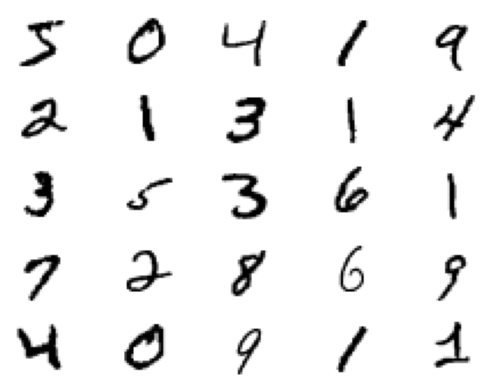

In [65]:
(x_train, y_train), (x_test, y_test) = load_data()
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')
plt.show()

In [66]:
(x_train, y_train), (_, _) = load_data()

In [67]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = (x_train - 127.5)/127.5

In [68]:
buffer_size = 60000
batch_size = 256

In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

Generator

In [70]:
def build_generator():
    model = tf.keras.Sequential()

    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 1)

    return model



In [71]:
gen = build_generator()

c:\Users\hanna m\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
noise = tf.random.uniform([1,100])
gen_image = gen(noise, training=False)

In [73]:
gen_image

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[ 1.43492222e-03],
         [ 8.68109346e-04],
         [-2.02498934e-03],
         [-3.92987742e-04],
         [ 1.05812668e-03],
         [ 2.76057818e-03],
         [ 8.76181410e-04],
         [ 6.87904144e-03],
         [-1.09734479e-03],
         [-3.80569929e-03],
         [-4.42746188e-03],
         [ 1.95844471e-03],
         [ 3.66538251e-03],
         [ 1.81897392e-03],
         [-3.61202378e-03],
         [-3.56459292e-03],
         [-1.34298264e-03],
         [ 9.90999397e-04],
         [ 3.48492013e-03],
         [-6.71961345e-04],
         [ 1.80012838e-03],
         [-2.44364003e-03],
         [-1.09789264e-03],
         [ 2.33998988e-04],
         [-1.02817616e-03],
         [-6.71446184e-03],
         [-3.89447715e-03],
         [-3.12866713e-03]],

        [[-1.49410486e-03],
         [ 6.23539090e-03],
         [ 1.73253182e-04],
         [-9.00290906e-03],
         [ 4.81420197e-04],
         [ 7.89624

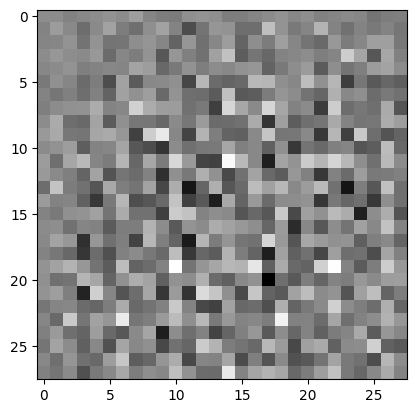

In [74]:
plt.imshow(gen_image[0,:,:,0], cmap='gray')

In [78]:
def discriminator():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [79]:
discriminator = discriminator()
decision = discriminator(gen_image)
print(decision)

tf.Tensor([[0.49979964]], shape=(1, 1), dtype=float32)


Defining the loss

In [80]:
cross_entropy = tf.losses.BinaryCrossentropy(from_logits=True)

In [81]:
def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

In [82]:
gen_optim = tf.keras.optimizers.Adam(1e-4)
disc_optim = tf.keras.optimizers.Adam(2e-4)

In [84]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, '.ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = gen_optim, 
                                 discriminator_optimizer = disc_optim, 
                                 generator = gen, 
                                 discriminator= discriminator)



In [85]:
epochs = 50 
noise_dim = 100 
num_examples = 16 

seed = tf.random.normal([16, noise_dim])